In [3]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import torch
import matplotlib.pyplot as plt
import imageio
from qutip import (fock, coherent, basis, destroy, qeye, tensor, wigner, mesolve, ptrace)

import pickle
import seaborn as sns

import glob
import os

## Task A

### Plotting

/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/87193564.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/87193564.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/87193564.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/87193564.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical in

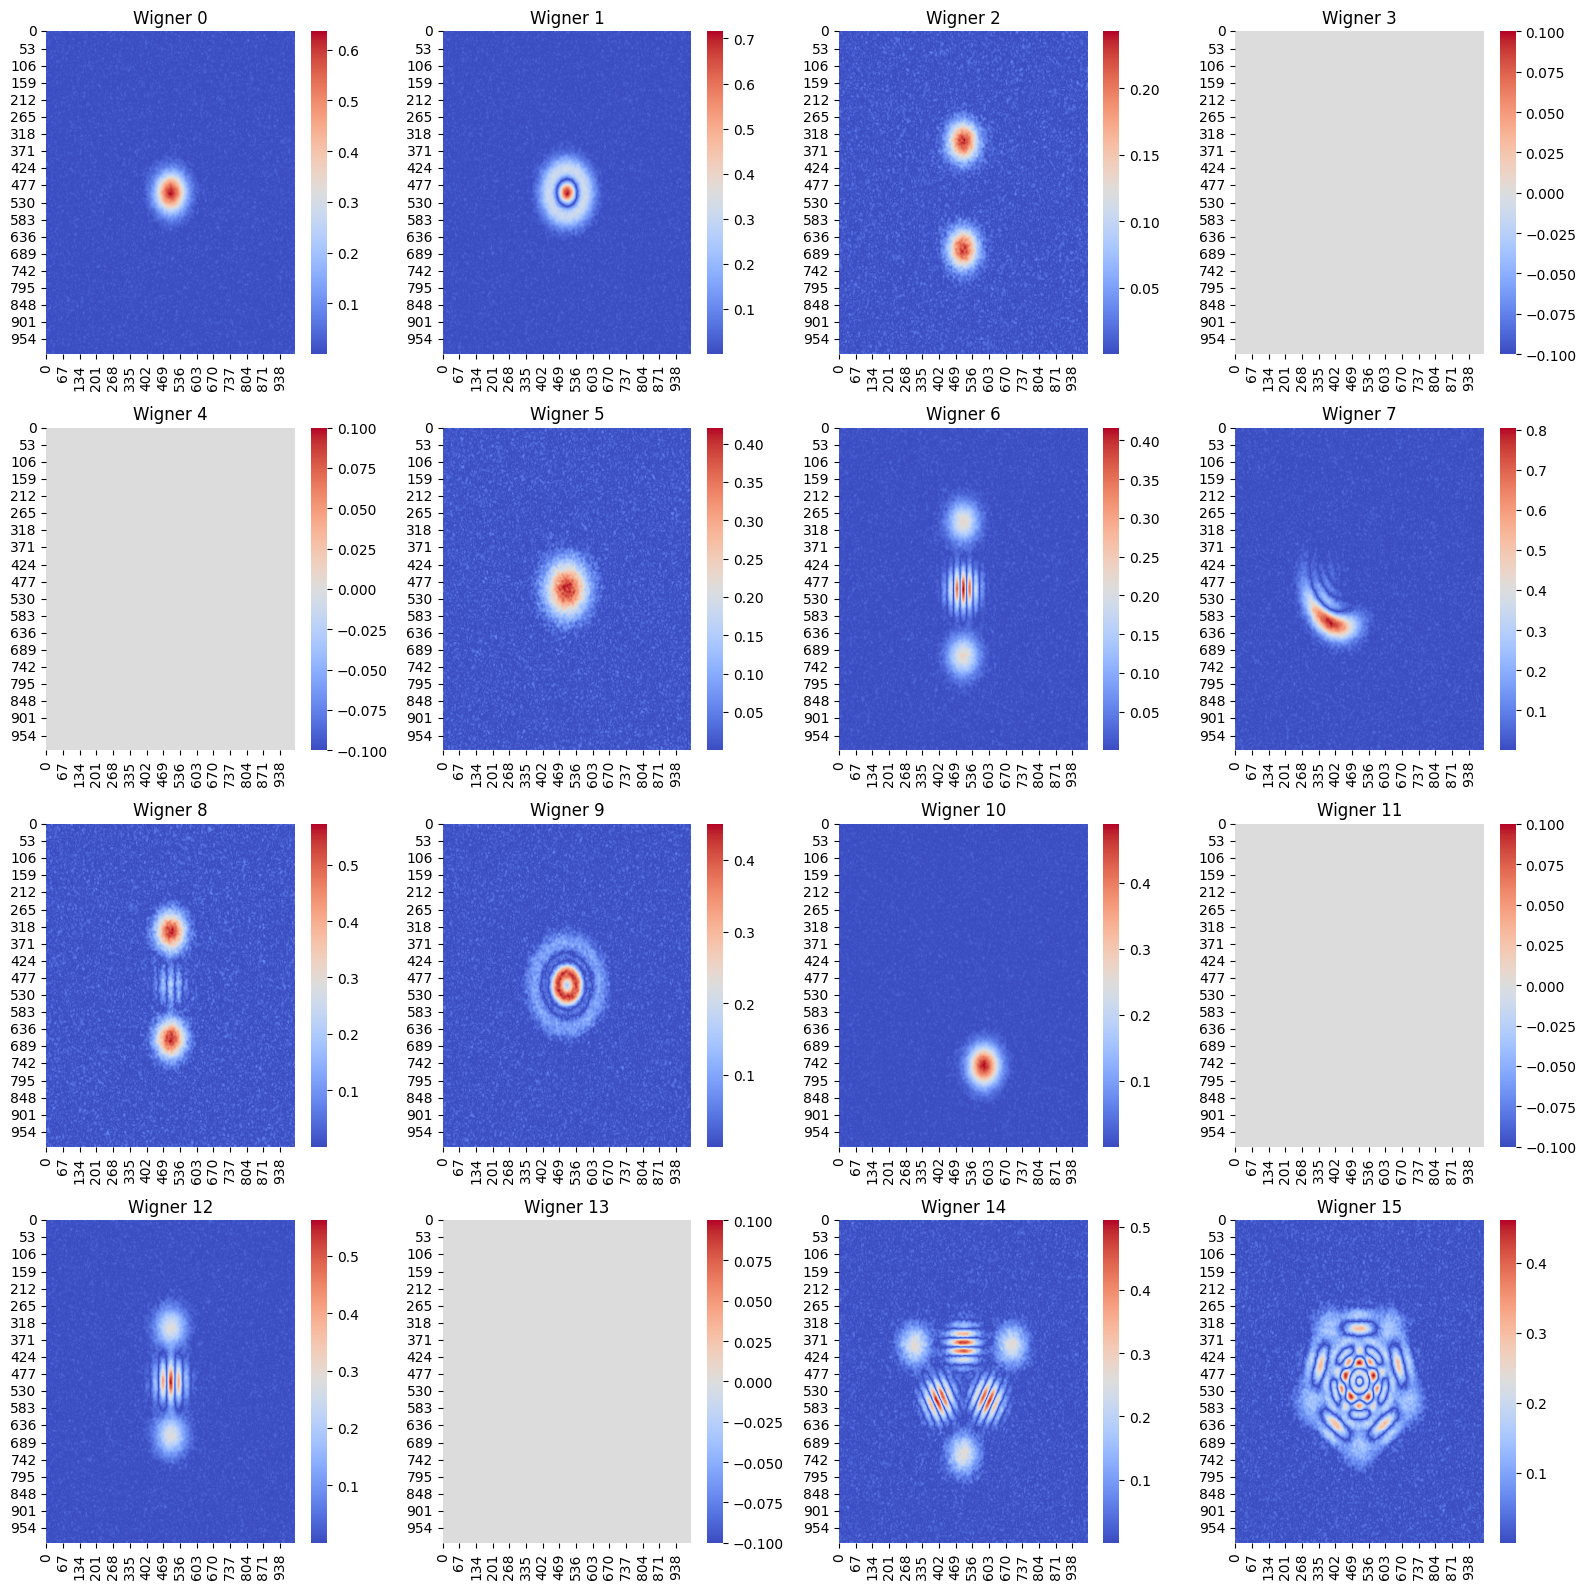

In [ ]:
from scipy.ndimage import gaussian_filter
wigner_files = sorted(glob.glob('../data/synthetic/noisy_wigner_*.pickle'))

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i, file_path in enumerate(wigner_files):
  if i >= 16: 
    break
    
  data = pickle.load(open(file_path, 'rb'))
  
  x = np.array(data[0])
  y = np.array(data[1])
  wigner_data = np.array(data[2])
  
  base_name = os.path.basename(file_path).replace('.pickle', '')
  np.save(f'../data/synthetic_npy/{base_name}_x.npy', x)
  np.save(f'../data/synthetic_npy/{base_name}_y.npy', y)
  np.save(f'../data/synthetic_npy/{base_name}_wigner.npy', wigner_data)
  
  axes[i].set_title(f'Wigner {i}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')
  axes[i].set_xticks([])
  axes[i].set_yticks([])


  # data cleaning
  edge_location = len(wigner_data) -1 
  b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
  wigner_data = wigner_data - b

  wigner_data[np.isnan(wigner_data)] = 0

  wigner_integral = np.trapz(np.trapezoid(wigner_data, x), y)
  wigner_data = wigner_data/ wigner_integral

  wigner_data[np.isnan(wigner_data)] = 0

  sigma = 3
  wigner_data = gaussian_filter(wigner_data, sigma=sigma)
  sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=axes[i])

  # sns.heatmap(wigner_data, cmap='coolwarm', cbar=False, ax=axes[i])

plt.tight_layout()
plt.show()

### Denoising

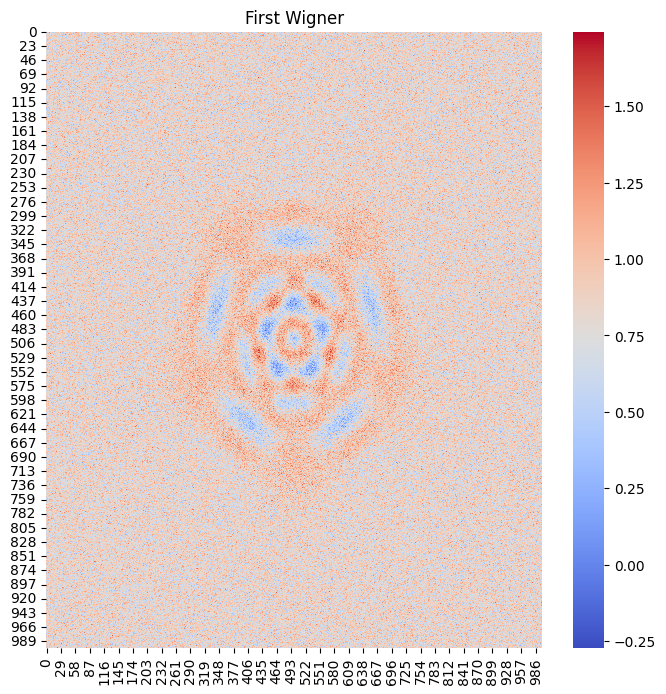

/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/3209010751.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral = np.trapz(np.trapz(wigner_data, x), y)


Wigner integral: 1.230240026717825


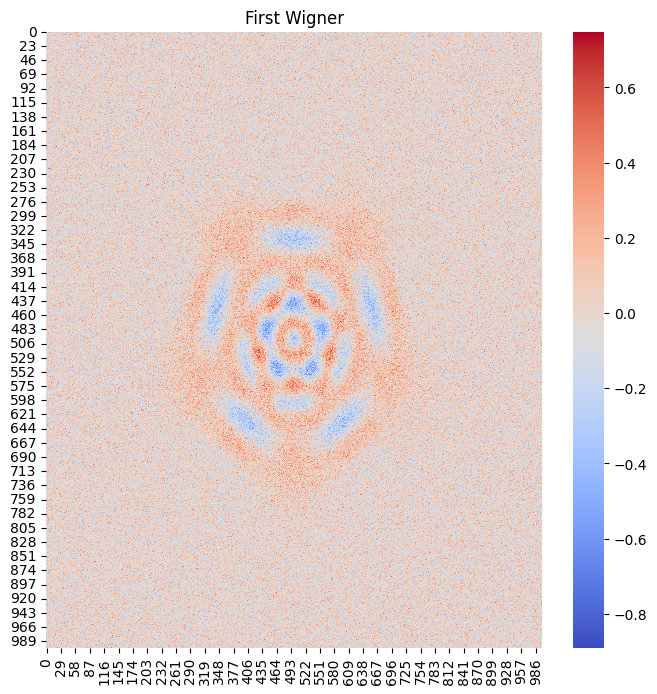

In [ ]:
# plot the data from the first file
data = pickle.load(open(wigner_files[14], 'rb'))
x = np.array(data[0])
y = np.array(data[1])
wigner_data = np.array(data[2])

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner')
plt.show()

# In most physical states, at the edges of phase space $W(x,p) \rightarrow0$.  This should allow you to estimate the value of $b$.
edge_location = len(wigner_data) -1 
b = (sum(wigner_data[edge_location, :]) + sum(wigner_data[:, edge_location]) + sum(wigner_data[0, :]) + sum(wigner_data[:, 0]))/(4 * edge_location)
wigner_data = wigner_data - b

# Normalize the Wigner function
wigner_integral = np.trapz(np.trapz(wigner_data, x), y)
wigner_data = wigner_data/ wigner_integral
print(f'Wigner integral: {wigner_integral}')


fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(wigner_data, cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner')
plt.show()

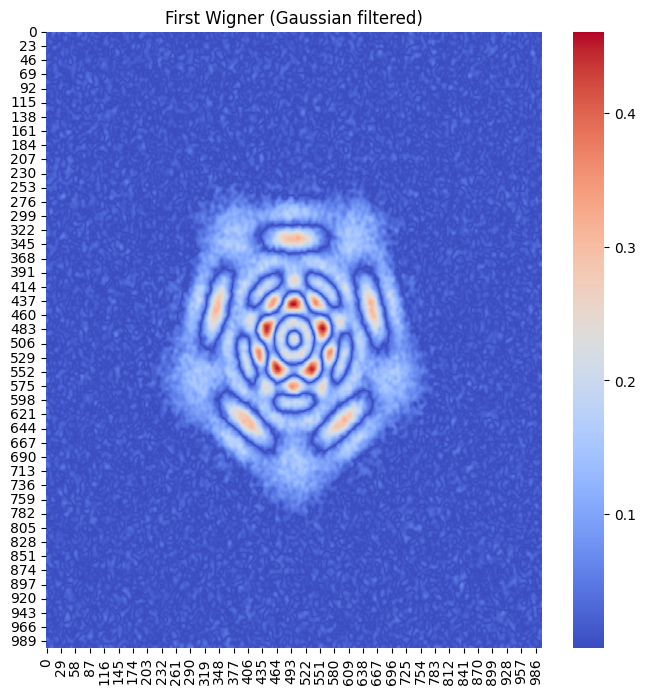

Wigner integral after filtering: 1.0001809917705062


/var/folders/_t/gm3l72kj3_g7pf01bszns77r0000gp/T/ipykernel_54884/602891714.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  wigner_integral_after = np.trapz(np.trapz(wigner_data, x), y)


In [71]:
# apply a 2D Gaussian filter to the Wigner function
from scipy.ndimage import gaussian_filter
sigma = 3
wigner_data = gaussian_filter(wigner_data, sigma=sigma)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(abs(wigner_data), cmap='coolwarm', cbar=True, ax=ax)
ax.set_title('First Wigner (Gaussian filtered)')
plt.show()
# Verify wigner integral after filtering
wigner_integral_after = np.trapz(np.trapz(wigner_data, x), y)
print(f'Wigner integral after filtering: {wigner_integral_after}')

Number of contours found: 93


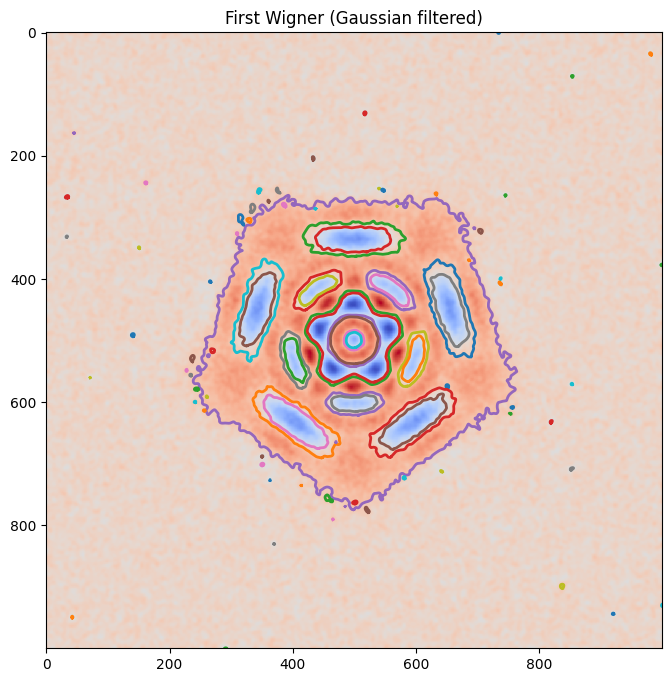

In [72]:
import skimage as ski
from skimage import measure

# use contour finding from skimage to find the contours of the Wigner function
contours = measure.find_contours(abs(wigner_data), 0.05)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(wigner_data, cmap='coolwarm', interpolation='nearest')
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.set_title('First Wigner (Gaussian filtered)')
print(f'Number of contours found: {len(contours)}')
plt.show()
